In [1]:
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower

In [2]:
from pycbc.waveform import get_td_waveform, td_approximants, fd_approximants
from pycbc import waveform
from scipy.signal import hilbert

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [3]:
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/camb


In [4]:
params = camb.CAMBparams()
# set Hubble paramter to present day (z=0) value
params.set_cosmology(H0 = 67.4)
results = camb.get_background(params, no_thermo = False)

print('derived parameter dictionary: %s'%results.get_derived_params()) # check age should be 13.8 billion years today

derived parameter dictionary: {'age': 13.803627360392127, 'zstar': 1090.3890548171307, 'rstar': 144.7164516349124, 'thetastar': 1.0422052952911642, 'DAstar': 13.885599342928161, 'zdrag': 1059.0744824572485, 'rdrag': 147.5072372553048, 'kd': 0.1401409172557956, 'thetad': 0.1614433969605452, 'zeq': 3393.3606596782656, 'keq': 0.010356886663518462, 'thetaeq': 0.8146724144654539, 'thetarseq': 0.4504179452772331}


In [5]:
z = 4
add = results.angular_diameter_distance(z) # ang diam distance to object at redshift z = 4
ld = results.luminosity_distance(z) # lum distance to same object (uses relationship to add, not apparent and absolute magnitudes)
print("angular diameter distance to object:", add, "luminosity distance to object:", ld)

angular diameter distance to object: 1467.6323788230309 luminosity distance to object: 36690.80947057577


In [6]:
# constants
c = 2.99792458e8 # m/s
G = 6.67259e-11 # m^3/kg/s^2 
M_sun = 1.989e30 # kg

## from www.gw-openscience.org
## source parameters
#m1 = 30 * M_sun
#m2 = 25 * M_sun
#M_total = m1 + m2
#eta = (m1*m2) / M_total**2 # symmetric mass ratio
#mchirp = M_total * eta**(3./5.) # chirp mass

## final BH mass is typically 95% of the total initial mass
#M_total_final = 0.95 * M_total
## Final BH radius
#R_final = 2 * G * M_total_final * M_sun / c**2/1000. # km

In [7]:
# List of td approximants that are available
#print(td_approximants())

# List of fd citapproximants that are currently available
#print(fd_approximants())

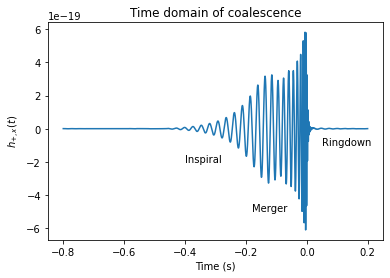

In [8]:
# plot time domain waveform

hp, hc = get_td_waveform(approximant = 'IMRPhenomC', mass1 = 30, mass2 = 25,
                         spin1z = 0.9, # z component of the first binary component’s dimensionless spin
                         delta_t = 1.0 / 4096, # time step used (from 4096 Hz frequency)
                         f_lower = 40 # starting frequency of waveform in Hz
                         #distance = 10 # luminosity distance in Mpc
                        )
plt.plot(hp.sample_times, hp)
    
plt.title('Time domain of coalescence')
plt.ylabel('$h_{+,x}(t)$')
plt.xlabel('Time (s)')
plt.annotate('Inspiral', (-.4,-2e-19))
plt.annotate('Merger', (-.18,-5e-19))
plt.annotate('Ringdown', (.05,-1e-19))
plt.show()

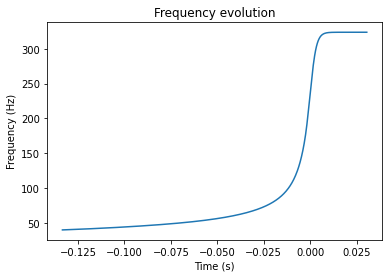

In [9]:
# plot frequency evolution of time domain waveform

hp, hc = waveform.get_td_waveform(approximant='SEOBNRv4HM', mass1 = 30, mass2 = 25, phase_order = 7, 
                                  delta_t = 1.0 / 4096, f_lower = 40)

hp, hc = hp.trim_zeros(), hc.trim_zeros()
amp = waveform.utils.amplitude_from_polarizations(hp, hc)
f = waveform.utils.frequency_from_polarizations(hp, hc)

plt.plot(f.sample_times, f)

plt.title('Frequency evolution')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()

In [10]:
# from scipy docu

t = np.asarray(hp.sample_times)
t0 = t
dt = 1.0 / 4096

analytic_signal = hilbert(np.asarray(hp))
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0 * np.pi * dt))

In [11]:
order = 1
fit = np.polyfit(t0, instantaneous_phase, order)
#print(fit)

In [12]:
p = np.poly1d(fit) # fit constant offset to the instaneous phase
phi_c = fit[0]
# if order > 0: print(fit[1] / 2 / np.pi)
# print(np.mod(phi_c,2*np.pi))
estimated = p(t0) # re-evaluate the offset term using the fitted values
offsetTerm = estimated
demodulated = instantaneous_phase - offsetTerm
signal = np.cos(demodulated + estimated) * np.abs(analytic_signal)

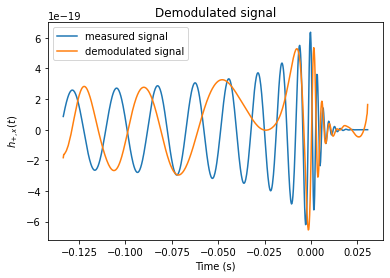

In [13]:
plt.figure()
plt.plot(t0,signal, label = 'measured signal') #demodulated signal
plt.plot(t0,np.cos(demodulated)*np.abs(analytic_signal), label = 'demodulated signal') 
plt.legend()
plt.title('Demodulated signal')
plt.ylabel('$h_{+,x}(t)$')
plt.xlabel('Time (s)')
plt.show()